# You're Toxic, I'm Slippin' Under: Toxic Comment Classification Challenge

#### STINTSY S13 Group 8
- VICENTE, Francheska Josefa
- VISTA, Sophia Danielle S.

## Introduction
In digital communities and forums on the internet, users often choose to remain anonymous as real names are not required when conversing with strangers online. With this anonymity comes the freedom to express one's thoughts without fear of being judged or recognized, yet this might also mean that users are free to say abusive sentiments with little to no repercussions. While most online forums and social media sites have various ways to moderate (e.g. moderators and staff that manually review posts and comments, a report button under messages, voting for comments and posts), these methods are not enough to combat the significant number of toxic comments made.

With this, ways to automate checking for toxicity in online text should be improved to foster a safe and respectful online environment.

## Toxic Comment Classification Challenge

The [`Toxic Comment Classification Challenge`](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) is a Kaggle challenge by the [`Conversation AI team`](https://conversationai.github.io/), which is composed of researchers from both [`Jigsaw`](https://jigsaw.google.com/) and `Google`. This challlenge invites participants to build a multi-headed model that can accurately detect the types of toxicity (i.e.,toxic, severe toxic, obscene, threat, insult, and identity hate) better than Perspective’s [current models](https://github.com/conversationai/unintended-ml-bias-analysis).

The dataset given contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

## Requirements and Imports
Before starting, the relevant libraries and files in building and training the model should be loaded into the notebook first.

### Import
Several libraries are required to perform a thorough analysis of the dataset. Each of these libraries will be imported and described below:

#### Basic Libraries 
Import `numpy` and `pandas`.
- `numpy` contains a large collection of mathematical functions
- `pandas` contains functions that are designed for data manipulation and data analysis

In [15]:
import numpy as np
import pandas as pd

#### Visualization Libraries 
- `matplotlib.pyplot` contains functions to create interactive plots
- `seaborn` is a library based on matplotlib that allows for data visualization
- `wordcloud` contains functions for generating wordclouds from text data

**NOTE:** `wordcloud` should be installed using `conda install -c conda-forge wordcloud`

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

#### Natural Language Processing Libraries 
- `nltk` asdasdas
- `stopwords` asdas
- `Counter` is from Python's `collections` module, which is helpful for tokenization

In [17]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

### Datasets and Files
There are four `.csv` files provided in the competition.
- `train.csv` is the training set, which contains comments and their classification (with the use of binary labels)
- `test.csv` is the test set, which contains comments and their corresponding IDs
- `sample_submission.csv` contains the correct submission format for the competition
- `test_labels.csv` was a file added after the competition closed

However, to do the task, we would only need to load two of these files: (1) `train.csv`, and (2) `test.csv`. These two `.csv` files will be loaded into the notebook using the [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

In [18]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

## Description of the Dataset

To see the the number of rows and columns for the `train` and `test` data, the [`shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) property of the DataFrame is called.

In [19]:
train.shape

(159571, 8)

The `train` data has 159571 rows (instances) and eight (8) columns (features). An instance in our dataset represents a text and its categories. 

Next, the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) function is called to check the first few rows of the dataset. This will let us quickly check the features of the dataset.

In [20]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


As seen by the function's output, the eight columns are: `id`, `comment_text`, `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. 

The first column `id` is an object that contains a unique identifier for the row. This is followed by the `comment_text` column, which holds the text that we need to categorize into the different toxic categories. The next six (6) columns—`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`—are integer columns, with a value of either 0 or 1, which represents `True` or `False`, respectively. These six columns represent the different categories. If the value for a specific column is 1, it means that the `comment_text` can be classified as this category.

It is important to note, however, that each `comment_text` can be classified under more than one toxic category (e.g. a comment can fall under both `toxic` and `severe_toxic` as denoted by the multiple values of 1 per row).

In [21]:
test.shape

(153164, 2)

On the other hand, the `test` dataset has 153164 rows and two (2) columns.

In [22]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Each instance represents a comment that we have to compute for its probaility for the different categories mentioned. Like the `train` data, the first column is the `id`, which is a unique identifier. After this is the `comment_text`, which holds the text that our model needs as input. 

## Exploratory Data Analysis (EDA)
In order to determine which model would fit our dataset, we would need to explore the given data. 

**Three exploratory data analysis questions have been identified and formulated:**
1. Which words occur most frequently in the `train` data?
2. Based on the `train` data, how correlated are the given categories?
3. What is the range of lengths of the `comment_text`?

To answer these questions, we used numerical summaries. Additionally, we used visualization techiniques in order to present and illustrate relationships in the data.

### Which words occur most frequently in the `train` data?

As a preliminary step in answering this question, all of the comments should be processed using tokenization, which is the process of separating pieces of text into words. 

For this, NLTK's [`RegexpTokenizer`](https://www.nltk.org/api/nltk.tokenize.regexp.html) is used to tokenize the text using RegEx. More specifically, the RegEx used is `\w+`, which retrieves all words (i.e. words with alphanumeric & underscore characters) from the text. Moreover, stopwords or common words based on NLTK's Stopword corpus were filtered out of the tokens for a more accurate count of relevant words. 

It should be noted that tokenization was done for each toxic classification and for all comments as a whole, to contrast the differences of the frequently seen words in each category.

In [23]:
nltk.download('stopwords')

words = []
obscene = []
insult = [] 
toxic = []
severe_toxic = [] 
identity_hate = [] 
threat = []
tokenizer = nltk.RegexpTokenizer(r'\w+')
for index, x in train.iterrows():
    text = x ['comment_text']
    words += tokenizer.tokenize(text.lower())
    
    if x ['obscene'] == 1:
        obscene += tokenizer.tokenize(text.lower())
    if x ['insult'] == 1:
        insult += tokenizer.tokenize(text.lower())
    if x ['toxic'] == 1:
        toxic += tokenizer.tokenize(text.lower())
    if x ['severe_toxic'] == 1:
        severe_toxic += tokenizer.tokenize(text.lower())
    if x ['identity_hate'] == 1:
        identity_hate += tokenizer.tokenize(text.lower())
    if x ['threat'] == 1:
        threat += tokenizer.tokenize(text.lower())
        
all_words = Counter(words)
all_obscene = Counter(obscene)
all_insult = Counter(insult)
all_toxic = Counter(toxic)
all_severe_toxic = Counter(severe_toxic)
all_identity_hate = Counter(identity_hate)
all_threat = Counter(threat)
for stopword in stopwords.words("english"): 
    all_words.pop(stopword, None)
    all_obscene.pop(stopword, None)
    all_insult.pop(stopword, None)
    all_toxic.pop(stopword, None)
    all_severe_toxic.pop(stopword, None)
    all_identity_hate.pop(stopword, None)
    all_threat.pop(stopword, None)

for alpha_char in list(string.ascii_lowercase + string.ascii_uppercase):
    all_words.pop(alpha_char, None)
    all_obscene.pop(alpha_char, None)
    all_insult.pop(alpha_char, None)
    all_toxic.pop(alpha_char, None)
    all_severe_toxic.pop(alpha_char, None)
    all_identity_hate.pop(alpha_char, None)
    all_threat.pop(alpha_char, None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To count the tokenized characters, Python's `Counter()` object was used to automatically count the number of tokens in the list of words retrieved above. The output for all the comments, arranged by total count in descending order, is as follows:

In [24]:
print('\n{}{}'.format('Token (All Comments)'.ljust(30), 'Count'))
for value, count in all_words.most_common(20):
    print('{}{}'.format(value.ljust(30), count))


Token (All Comments)          Count
article                       57661
wikipedia                     48427
page                          46460
talk                          37094
please                        29794
would                         29323
one                           29179
like                          28008
see                           21603
also                          20641
think                         20084
know                          19144
people                        18468
edit                          18288
articles                      16712
use                           16594
time                          15885
may                           15611
user                          14101
thanks                        13904


Next, the tokens for each toxic category will be shown below, arranged by total count in descending order.

In [25]:
print('\n{}{}'.format('Token (Insult)'.ljust(30), 'Count'))
for value, count in all_insult.most_common(10):
    print('{}{}'.format(value.ljust(30), count))

print('\n{}{}'.format('Token (Obscene)'.ljust(30), 'Count'))
for value, count in all_obscene.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Toxic)'.ljust(30), 'Count'))
for value, count in all_toxic.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Severe Toxic)'.ljust(30), 'Count'))
for value, count in all_severe_toxic.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Identity Hate)'.ljust(30), 'Count'))
for value, count in all_identity_hate.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Threat)'.ljust(30), 'Count'))
for value, count in all_threat.most_common(10):
    print('{}{}'.format(value.ljust(30), count))


Token (Insult)                Count
fuck                          7925
fucking                       2799
suck                          2792
nigger                        2781
go                            2235
ass                           2211
fat                           1926
faggot                        1867
bitch                         1733
shit                          1689

Token (Obscene)               Count
fuck                          9860
shit                          3212
fucking                       3192
suck                          3021
ass                           2846
nigger                        2727
go                            2147
wikipedia                     1905
bitch                         1795
like                          1541

Token (Toxic)                 Count
fuck                          9934
wikipedia                     3678
shit                          3622
like                          3512
nigger                        3300
fucking       

For a better visual representation of the frequency of these words, these words may be displayed in a wordcloud. Wordclouds are apt for this task as they give prominence to words based on their frequency.

A [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) object is generated below, using the tokens from all comments.

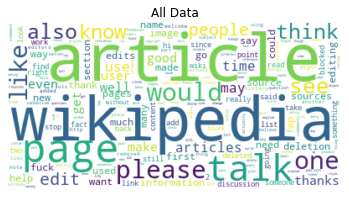

In [26]:
wordcloud = WordCloud(min_word_length = 3, background_color='white')
wordcloud.generate_from_frequencies(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('All Data')
plt.axis('off')
plt.show()

Next, several [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) objects are generated using the tokens from each toxic category as follows:

#### Figure 1. Wordcloud of the Word Frequency of All of the Data

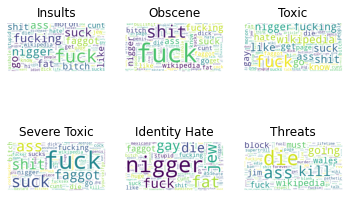

In [27]:
fig = plt.figure()

ax2 = fig.add_subplot(231)
wordcloud1 = WordCloud(min_word_length = 3, background_color='white')
wordcloud1.generate_from_frequencies(all_insult)
plt.imshow(wordcloud1)
plt.title('Insults')
plt.axis('off')

ax3 = fig.add_subplot(232)
wordcloud2 = WordCloud(min_word_length = 3, background_color='white')
wordcloud2.generate_from_frequencies(all_obscene)
plt.imshow(wordcloud2)
plt.title('Obscene')
plt.axis('off')

ax4 = fig.add_subplot(233)
wordcloud3 = WordCloud(min_word_length = 3, background_color='white')
wordcloud3.generate_from_frequencies(all_toxic)
plt.imshow(wordcloud3)
plt.title('Toxic')
plt.axis('off')

ax5 = fig.add_subplot(234)
wordcloud4 = WordCloud(min_word_length = 3, background_color='white')
wordcloud4.generate_from_frequencies(all_severe_toxic)
plt.imshow(wordcloud4)
plt.title('Severe Toxic')
plt.axis('off')

ax6 = fig.add_subplot(235)
wordcloud5 = WordCloud(min_word_length = 3, background_color='white')
wordcloud5.generate_from_frequencies(all_identity_hate)
plt.imshow(wordcloud5)
plt.title('Identity Hate')
plt.axis('off')

ax7 = fig.add_subplot(236)
wordcloud6 = WordCloud(min_word_length = 3, background_color='white')
wordcloud6.generate_from_frequencies(all_threat)
plt.imshow(wordcloud6)
plt.title('Threats')
plt.axis('off')

plt.show()

#### Figure 2. Wordcloud of the Word Frequency of Each of the Categories

From the list of frequent words and the wordcloud generated above,

As expected of comments retrieved from Wikipedia's talk page edits, many of the words seen in the table and wordcloud relate to Wikipedia itself (`article`, `articles`, `wikipedia`, `talk`, `page`, `edit`) and some words involve collaboration and communication between users for edits (`user`, `would`, `like`, `think`, `know`). Words such as `please` and `thanks` can be seen, indicating that many comments are civil and respectful.


from both d word cloud and d dictionary, bakit related to wikipedia ung mga most frequent words???? pero from ung mga mostly occurring words, makikita natin na di sila pasok sa categories?? like pwede natin sila iconsider sa "clean words"?

### Based on the `train` data, how correlated are the given categories?
Since this challenge mainly focuses on determining the probability of a comment belonging to a specific category, we want to explore the correlations among the different categories. The correlation of each of the categories is computed using Pandas' [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function. 

It should be noted that since there are only two values—0 and 1—possible for each of the category, we would not have to worry for outliers.

In [29]:
correlation = train.corr()
correlation

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


Since it is hard to determine the correlation of the categories using just numbers, we can visualize these numbers using a [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<AxesSubplot:>

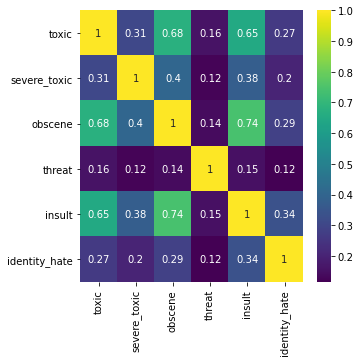

In [32]:
plt.figure (figsize = (5, 5))
sns.heatmap (data = correlation, xticklabels = correlation.columns.values, yticklabels = correlation.columns.values, cmap = 'viridis', annot=True)

#### Figure 3. Correlation Heatmap of the categories
From Figure 3, we can see that there is a low correlation between threat and all of the other categories. Additionally, **insult** and **obscene** has the highest correlation among the categories with a 0.74 or 74% correlation.

### What is the range of length of `comment_text`?

Determining the range of the length of the string `comment_text` could help us in determining on how long are the words, phrases or sentences our model needs to handle. The length of the longest string can be determined through the use of the [`len`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html) and [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) functions.

In [25]:
train['comment_text'].str.len().describe()

count    159571.000000
mean        396.593961
std         594.387869
min           6.000000
25%          97.000000
50%         207.000000
75%         438.000000
max        5000.000000
Name: comment_text, dtype: float64

From this, we can see that there is at least one string in the `comment_text` column with a length of 5000. This is far from the mean length, which is only 396.

To visualize how this length happen, we can sort our data frame (i.e., using the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) function) based on the length of the `comment_text` column, from the longest to the shortest.

In [26]:
arranged_index  = train['comment_text'].str.len().sort_values(ascending = False).index
arranged_length = train.reindex (arranged_index)

length = train['comment_text'].str.len().sort_values(ascending = False)
arranged_length ['string_length'] = length
arranged_length

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,string_length
131729,c0e076f0011acaa6,"""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...",1,1,1,0,1,0,5000
133254,c8f01ac90c4adc27,FUCK YOU ALL!! FUCK YOU ALL!! FUCK YOU ALL!!...,1,1,1,0,1,0,5000
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,5000
56834,97e695cfd71944ed,i CAN STILL POST WITH THIS COMPUTER...I SAID B...,1,1,1,0,1,0,5000
156437,ce2d7821188dd30f,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGO...,1,1,1,0,1,1,5000
...,...,...,...,...,...,...,...,...,...
118850,7b3d18857df782cf,FUCK YOU,1,1,1,0,1,0,8
121074,87c06f935f2c6559,you suck,1,0,1,0,1,0,8
109985,4c5cde3ab1a618c9,{{unbloc,0,0,0,0,0,0,8
52442,8c4c53001134f290,"14:53,",0,0,0,0,0,0,6


As we can see, there are more than one rows with a string length of 5000. From the five shown, we can see that it is mostly made up of uppercase characters and repeating words.

Additionally, we can see that there are **42 rows** that has a string length of 5000 for the `comment_text` column. 

In [27]:
len(arranged_length [arranged_length ['string_length'] == 5000])

42

Through the use of a [`box`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.box.html) plot, we can see how dispersed our data is.

<AxesSubplot:>

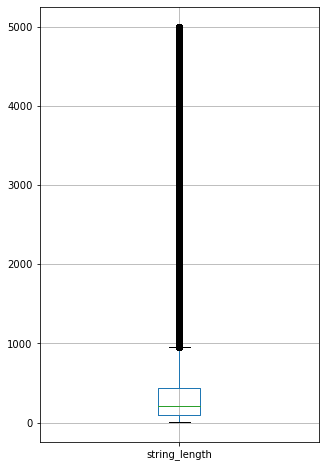

In [28]:
arranged_length ['string_length'].plot.box(grid='True', figsize=(5, 8))

#### Figure 4. Box Plot of the Length of `comment_text`
Using Figure 4, we can see that there are outliers in the length of the `comment_text` as there are lengths that are higher than the upper whisker. Additionally, this also visually show what we have learned in the output of the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function: 50% of the length of the `comment_text` column can be found within the range of 97 and 438, with an Interquartile range (IQR) of 341.

## Data Pre-Processing and Cleaning

## Feature Engineering

## Model Training

## Feature Selection and Hyperparameter tuning

## Model Selection

## Insights and Conclusions

## Testing the Model

## References
https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb